<a href="https://colab.research.google.com/github/bylehn/auxetic_networks_jaxmd/blob/abhishek/test-auxetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as np
import numpy as onp
from jax import random
from jax.config import config; config.update("jax_enable_x64", True)
from jax_md import space, energy, minimize, simulate, quantity
from jax import random, grad
from jax import jit, vmap
from jax import lax
from jax.debug import print as jax_print
from jax.core import ShapedArray
import networkx as nx
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from functools import reduce
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [56]:
!pip install JSAnimation

In [2]:
def createDelaunayGraph(NS, rseed, r_c, del_x):

    # This function creates a Delaunay graph of a set of points.

    # Parameters:
    #   NS: The number of points to generate.
    #   rseed: The random seed to use.
    #   r_c: The radius of the circumcircle of each edge in the graph.
    #   del_x: max noise magnitude from square lattice

    # Returns:
    #   N: The number of points in the graph.
    #   G: The graph object.
    #   X: The coordinates of the points.
    #   E: The edges of the graph.

    # Set the random seed.
    onp.random.seed(rseed)

    # Generate the points.
    xm, ym = onp.meshgrid(onp.arange(1, NS + 1), onp.arange(1, NS + 1))
    X = onp.vstack((xm.flatten(), ym.flatten())).T
    N = X.shape[0]

    # Add some noise to the points.
    X = X + del_x * 2 * (0.5 - onp.random.rand(N, 2))

    # Create the Delaunay triangulation.
    DT = Delaunay(X)

    # Get the edges of the triangulation.
    ET = onp.empty((0, 2), dtype=int)
    for T in DT.simplices:
        ET = onp.vstack((ET, [T[0], T[1]], [T[1], T[2]], [T[0], T[2]]))

    # Sort the edges.
    ET = onp.sort(ET)

    # Get the radii of the circumcircles of the edges.
    R = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with radii less than r_c.
    EN = ET[R < r_c, :]

    # Create the adjacency matrix.
    A = onp.zeros((N, N))
    A[EN[:, 0], EN[:, 1]] = 1

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with lengths less than r_c.
    EL = L[R < r_c]

    # Create the graph object.
    G = nx.Graph(A)

    # Get the edges of the graph.
    E = onp.array(G.edges)

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[E[:, 0], :] - X[E[:, 1], :], axis=1)

    return N, G, X, E, L

def getSurfaceNodes(G, NS):
    # Retrieve the list of nodes in the graph G
    nodes = np.array(list(G.nodes))
    # Calculate the x and y coordinates of the nodes based on the grid size NS
    x_values = nodes % NS
    y_values = nodes // NS
    # Find the nodes located on the top surface (y = NS - 1)
    top_nodes = nodes[y_values == NS - 1]
    # Find the nodes located on the bottom surface (y = 0)
    bottom_nodes = nodes[y_values == 0]
    # Find the nodes located on the left surface (x = 0)
    left_nodes = nodes[x_values == 0]
    # Find the nodes located on the right surface (x = NS - 1)
    right_nodes = nodes[x_values == NS - 1]
    # Return a dictionary with surface names as keys and node arrays as values
    return {
        'top': top_nodes,
        'bottom': bottom_nodes,
        'left': left_nodes,
        'right': right_nodes
    }

In [3]:
def make_box(R, padding):
    """
    Defines a box length

    R: position matrix
    padding: amount of space to add to the box
    """
    box_length = (np.max((np.max(R[:,0], R[:,1])) - np.min(((np.min(R[:,0], R[:,1])))))) + padding
    return box_length
    
def create_spring_constants(R,E,k_1):
    """
    Creates spring constants for each edge in the graph

    k_1: spring constant for a spring of unit length
    R: position matrix
    E: edge matrix
    """
    displacements = R[E[:, 0],:] - R[E[:, 1], :]
    distance = np.linalg.norm(displacements, axis=1)
    return (k_1/distance).reshape(-1,1), distance

@jit
def compute_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


#@jit
def constrained_force_fn(R, energy_fn, left_indices, right_indices, mask):
    """
    Calculates forces with frozen edges.

    R: position matrix
    energy_fn: energy function
    left_indices: indices of left boundary nodes
    right_indices: indices of right boundary nodes
    """
    
    
    def new_force_fn(R):
        force_fn = quantity.force(energy_fn)
        total_force = force_fn(R)
        total_force *= mask
        return total_force

    return new_force_fn


@jit
def fitness(poisson):
    """
    Constructs a fitness function based on the Poisson ratio.
    """
    return (poisson + 1)**2

@jit
def poisson_ratio(initial_horizontal, initial_vertical, final_horizontal, final_vertical):
    """
    Calculate the Poisson ratio based on average edge positions.
    
    initial_horizontal: initial horizontal edge positions
    initial_vertical: initial vertical edge positions
    final_horizontal: final horizontal edge positions
    final_vertical: final vertical edge positions
    output: Poisson ratio
    """

    delta_horizontal = final_horizontal - initial_horizontal
    delta_vertical = final_vertical - initial_vertical

    return -delta_vertical / delta_horizontal

@jit
def update_kbonds(gradients, k_bond, learning_rate = 0.01):
    """
    Updates spring constants based on gradients.

    
    """
    gradients_perpendicular = gradients - np.mean(gradients)
    gradients_normalized = gradients_perpendicular / np.max(gradients_perpendicular)
    k_bond_new = k_bond * (1 - learning_rate * gradients_normalized)

    return k_bond_new

@jit
def compute_force_norm(fire_state):
    return np.linalg.norm(fire_state.force)


def remove_zero_rows(log_dict):
    """
    Remove rows (entries) in the log dictionary that are all zeros.
    """
    for key in log_dict:
        log_dict[key] = log_dict[key][~np.all(log_dict[key] == 0.0, axis=(1, 2))]
    return log_dict

@jit
def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    cos_angle = dot_product / magnitude_product
    angle = np.arccos(cos_angle)
    return angle

@jit
def harmonic_angle_energy(bond_angles, Ka, theta0):
    return Ka * (bond_angles - theta0)**2

def compute_theta0(E, R):
    def bonded_angles(E):
        I, J = onp.triu_indices(E.shape[0], k=1)
        mask1 = E[I, 0] == E[J, 0]
        ai1 = np.stack([E[I[mask1], 1], E[I[mask1], 0], E[J[mask1], 1]], axis=-1)
        mask2 = E[I, 0] == E[J, 1]
        ai2 = np.stack([E[I[mask2], 1], E[I[mask2], 0], E[J[mask2], 0]], axis=-1)
        mask3 = E[I, 1] == E[J, 0]
        ai3 = np.stack([E[I[mask3], 0], E[I[mask3], 1], E[J[mask3], 1]], axis=-1)
        mask4 = E[I, 1] == E[J, 1]
        ai4 = np.stack([E[I[mask4], 0], E[I[mask4], 1], E[J[mask4], 0]], axis=-1)

        return np.concatenate([ai1, ai2, ai3, ai4], axis=0)
    angles = bonded_angles(E)

        # Vectorized calculation of displacement vectors
    @vmap
    def compute_displacements(triplet):
        i, j, k = triplet
        return np.array([displacement(R[i], R[j]), displacement(R[k], R[j])])

    displacements = compute_displacements(angles)

        # Vectorized calculation of bond angles
    @vmap
    def compute_angle(dR):
        return angle_between_vectors(dR[0], dR[1])

    theta0 = compute_angle(displacements)
    return theta0

In [45]:
steps = 50
write_every = 1
perturbation = 8.0
delta_perturbation = 0.1


def simulate_auxetic(R, k_bond, k_angle, shift, surface_nodes, perturbation, delta_perturbation, displacement, E, bond_lengths, theta0, optimize = True):
    """
    Simulates the auxetic process.

    """
    # Get the surface nodes.
    top_indices = surface_nodes['top']
    bottom_indices = surface_nodes['bottom']
    left_indices = surface_nodes['left']
    right_indices = surface_nodes['right']  
    mask = np.ones(R.shape)   
    mask = mask.at[left_indices].set(0)
    mask = mask.at[right_indices].set(0)
    num_iterations = int(np.ceil(perturbation / delta_perturbation))


    cumulative_perturbation = 0.0

    log = {
            'force': np.zeros((num_iterations*(steps // write_every),) + R.shape),
            'position': np.zeros((num_iterations*(steps // write_every),) + R.shape),
    }

    def step_fn_generator(apply, start_idx):
        def step_fn(i, state_and_log):
            """
            Minimizes the configuration at each step.

            i: step number
            state_and_log: state and log dictionary
            """
            fire_state, log = state_and_log
            i_adjusted = i + start_idx
            log['force'] = lax.cond(i_adjusted % write_every == 0,
                                        lambda p: p.at[i_adjusted // write_every].set(fire_state.force),
                                        lambda p: p,
                                        log['force'])
            
            log['position'] = lax.cond(i_adjusted % write_every == 0,
                                            lambda p: p.at[i_adjusted // write_every].set(fire_state.position),
                                            lambda p: p,
                                            log['position'])
            
            fire_state = apply(fire_state)
            return fire_state, log

        return step_fn

    def perturb_and_minimize(i, state_log_perturb):
        R_current, log, cumulative_perturbation = state_log_perturb
        R_perturbed = R_current.at[left_indices, 0].add(delta_perturbation)
        cumulative_perturbation += delta_perturbation 
        # Update the force function with the new positions
        force_fn = constrained_force_fn(R_perturbed, energy_fn_wrapper, left_indices, right_indices, mask)

        # Reinitialize the fire state with the new positions and updated force function
        fire_init, fire_apply = minimize.fire_descent(force_fn, shift)
        fire_state = fire_init(R_perturbed)

        # Update step function generator with the new start index

        start_idx = i * (steps // write_every)

        step_fn = step_fn_generator(fire_apply, start_idx)

        # Perform the minimization step
        fire_state, log = lax.fori_loop(0, steps, step_fn, (fire_state, log))
        R_perturbed = fire_state.position
        
        return R_perturbed, log, cumulative_perturbation

    def bonded_angles(E):
        I, J = onp.triu_indices(E.shape[0], k=1)
        mask1 = E[I, 0] == E[J, 0]
        ai1 = np.stack([E[I[mask1], 1], E[I[mask1], 0], E[J[mask1], 1]], axis=-1)
        mask2 = E[I, 0] == E[J, 1]
        ai2 = np.stack([E[I[mask2], 1], E[I[mask2], 0], E[J[mask2], 0]], axis=-1)
        mask3 = E[I, 1] == E[J, 0]
        ai3 = np.stack([E[I[mask3], 0], E[I[mask3], 1], E[J[mask3], 1]], axis=-1)
        mask4 = E[I, 1] == E[J, 1]
        ai4 = np.stack([E[I[mask4], 0], E[I[mask4], 1], E[J[mask4], 0]], axis=-1)

        return np.concatenate([ai1, ai2, ai3, ai4], axis=0)
    
    def energy_fn(R, E, k_angle, theta0, k_bond, bond_lengths, **kwargs):
        angles = bonded_angles(E)

        # Vectorized calculation of displacement vectors
        @vmap
        def compute_displacements(triplet):
            i, j, k = triplet
            return np.array([displacement(R[i], R[j]), displacement(R[k], R[j])])

        displacements = compute_displacements(angles)

        # Vectorized calculation of bond angles
        @vmap
        def compute_angle(dR):
            return angle_between_vectors(dR[0], dR[1])

        bond_angles = compute_angle(displacements)

        # Calculate angle energy
        angle_energy = harmonic_angle_energy(bond_angles, k_angle, theta0)

        # Bond energy (assuming that simple_spring_bond is JAX-compatible)
        bond_energy = energy.simple_spring_bond(displacement, E, length=bond_lengths, epsilon=k_bond[:, 0])(R, **kwargs)
     
        return bond_energy + np.sum(angle_energy)

    def energy_fn_wrapper(R, **kwargs):
        return energy_fn(R, E, k_angle, theta0, k_bond, bond_lengths, **kwargs)
        
    R_init = R
    # Initial dimensions (before deformation)
    # Exclude the first and last index for horizontal edges (top and bottom)
    # as these are corners with the left and right edges
    initial_horizontal = np.mean(R_init[right_indices[1:-1]], axis=0)[0] - np.mean(R_init[left_indices[1:-1]], axis=0)[0]

    # Exclude the first and last index for vertical edges (left and right)
    # as these are corners with the top and bottom edges
    initial_vertical = np.mean(R_init[top_indices[1:-1]], axis=0)[1] - np.mean(R_init[bottom_indices[1:-1]], axis=0)[1]

    R_final, log, cumulative_perturbation = lax.fori_loop(0, num_iterations, perturb_and_minimize, (R_init, log, cumulative_perturbation))
    # Final dimensions (after deformation)
    final_horizontal = np.mean(R_final[right_indices[1:-1]], axis=0)[0] - np.mean(R_final[left_indices[1:-1]], axis=0)[0]
    final_vertical = np.mean(R_final[top_indices[1:-1]], axis=0)[1] - np.mean(R_final[bottom_indices[1:-1]], axis=0)[1]

    # Calculate the poisson ratio.
    poisson = poisson_ratio(initial_horizontal, initial_vertical, final_horizontal, final_vertical)
    #fit = fitness(poisson)
    
    if optimize == True:
        return poisson
    else: return poisson, log, R_init, R_final

    

In [46]:
#create graph
number_of_nodes_per_side = 10
N,G,X,E,bond_lengths =createDelaunayGraph(number_of_nodes_per_side, 25, 2.0, 0.4)
R = np.array(X)
k_angle = 1e-1
k_bond, _ = create_spring_constants(R,E,1.0)
surface_nodes = getSurfaceNodes(G, number_of_nodes_per_side)
displacement, shift = space.free() #displacement = points in space, shift = small shifts of each particle
theta0 = compute_theta0(E, R)
grad_f = grad(simulate_auxetic, argnums=1) 

In [47]:
poisson, log, R_init, R_final = simulate_auxetic(R, k_bond, k_angle, shift, surface_nodes, perturbation, delta_perturbation, displacement, E, bond_lengths, theta0, optimize = False)

In [49]:
log['position'][4000]

Array([[ 8.70390069,  0.93417846],
       [ 7.63542132,  1.02930169],
       [ 6.87105707,  1.28037351],
       [ 7.11035061,  2.05011776],
       [ 7.41499276,  2.69856685],
       [ 7.54830782,  2.01382566],
       [ 7.8220824 ,  1.32053086],
       [ 8.61697   ,  1.17407983],
       [ 9.23849644,  0.94585329],
       [10.10688436,  0.73090039],
       [ 9.01492565,  1.98679816],
       [ 7.81675929,  1.44567841],
       [ 6.75334524,  1.81826159],
       [ 6.45212736,  2.52605883],
       [ 6.61111111,  2.76432238],
       [ 7.23555038,  2.08585692],
       [ 7.75705291,  2.40872983],
       [ 8.70172738,  2.16710142],
       [ 9.26706463,  1.88409809],
       [ 9.737323  ,  1.74104444],
       [ 9.33828774,  2.88411034],
       [ 7.99967077,  2.97576943],
       [ 7.30199596,  2.65723522],
       [ 5.83893569,  3.17855695],
       [ 6.69146787,  3.36839073],
       [ 7.36554545,  3.25640588],
       [ 8.18322491,  3.39710089],
       [ 8.5907864 ,  3.20517287],
       [ 9.27240597,

In [ ]:
poisson

In [ ]:
opt_steps = 3
k_temp = k_bond
for i in range(opt_steps):
    gradients = grad_f(R, k_temp, k_angle, shift, surface_nodes, perturbation, displacement, E, bond_lengths, theta0)
    net_fitness = simulate_auxetic(R, k_temp, k_angle, shift, surface_nodes, perturbation, displacement, E, bond_lengths, theta0)
    k_bond = k_temp
    k_temp = update_kbonds(gradients, k_temp)
    print(i, np.max(gradients), net_fitness)

In [ ]:
poisson, log, R_init, R_final, fire_state = simulate_auxetic(R, k_bond, k_angle, shift, surface_nodes, perturbation, displacement, E, bond_lengths, theta0, optimize = False)

In [ ]:
traj = log['first_min']['position'] + log['second_min']['position']

In [ ]:
poisson

In [ ]:
def getBondImportance(X,C,V,D,D_range):
    modes = onp.where((D > D_range[0]) & (D < D_range[1]))[0]
    delta_E=C.T@V
    EC=delta_E[:,modes]
    bondImportance=onp.mean(np.abs(EC),axis=1)
    return bondImportance/onp.max(bondImportance)



def createCompatibility(N,X,E):
    
    N_b = E.shape[0]
    mdict=dict(zip(range(N), m))
    nx.set_node_attributes(G,mdict,'Mass')
    C = onp.zeros((2 * N, N_b))
    
    for i in range(N_b):
        b_vec = X[E[i, 0], :] - X[E[i, 1], :]
        b_vec = b_vec / np.linalg.norm(b_vec)
        for ki in range(2):
            j = E[i, ki]
            xind = 2 * j 
            C[xind:xind + 2, i] = ((-1) ** ki) * b_vec
    

    return C


def getForbiddenModes(C, k, M, w_c, dw):
    kd = onp.diag(np.squeeze(k))
    K = C @ kd @ C.T
    DMAT = np.linalg.inv(M) @ K
    D, V = onp.linalg.eig(DMAT)
    D = onp.real(D)
    w=onp.sqrt(onp.abs(D))
    forbidden_states=onp.sum(onp.logical_and(w>w_c-dw/2,w<w_c+dw/2))
    V=onp.real(V)
    return D, V,forbidden_states

def ageSprings(k_old,X,C,V,D,D_range,ageing_rate):
    bond_importance=getBondImportance(X,C,V,D,D_range)
    bond_importance_centered=bond_importance-onp.mean(bond_importance)
    bond_importance_normalized=bond_importance_centered/onp.max(onp.abs(bond_importance_centered))

    k_new=k_old*(1+2*ageing_rate*bond_importance_normalized)
    return k_new
def optimizeAgeing(C, k, M, w_c, dw, N_trials,ageing_rate,success_frac):
    w_range=[w_c-dw/2,w_c+dw/2]
    D_range = [x**2 for x in w_range]
    D, V, forbidden_states_initial = getForbiddenModes(C, k, M, w_c, dw)
    if forbidden_states_initial==0:
        return k,1,0
    for trial in range(1, N_trials+1):
        k=ageSprings(k,X,C,V,D,D_range,ageing_rate)
    
        D, V, forbidden_states = getForbiddenModes(C, k, M, w_c, dw)
        print(trial,forbidden_states)
    
        if forbidden_states<=success_frac*forbidden_states_initial:
            
            return k, 1,trial
    
    return k,0,trial
    



N_trials=1000
dw=0.2
w_c=2.0

ageing_rate=0.01
success_frac=0.05
freq_range=[w_c-dw/2,w_c+dw/2]
D_range = [x**2 for x in freq_range]

F_stack=[]



#N,G,X,E,L=createDelaunayGraph(11, 1215456, 2.0, 0.30)


#k,L=create_spring_constants(X, E, 1)
#k=k.T
m = onp.ones(N)
mdict=dict(zip(range(N), m))
nx.set_node_attributes(G,mdict,'Mass')

C=createCompatibility(N,X,E)

m2 = onp.zeros(2 * N)
m2[0:2 * N:2] = m
m2[1:2 * N:2] = m
M = onp.diag(m2)

k2,result_flag,final_trial=optimizeAgeing(C, k_bond.T, M, w_c, dw, N_trials,ageing_rate,success_frac)


fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
pos = dict(zip(range(N), X))
edges=nx.draw_networkx_edges(G, pos, width=2*k2/k, alpha=0.6,edge_color='k')
plt.title("Graph Final")

plt.subplot(1,3, 2)
D, V, forbidden_states = getForbiddenModes(C, k2, M, w_c, dw)
plt.hist(onp.sqrt(onp.abs(D)), bins=onp.arange(-0.025, 4.025, 0.05), density=True)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
print(str(forbidden_states)+' Forbidden States')


plt.subplot(1,3, 3)

plt.hist(k2/k, bins=onp.arange(-0.025, np.max(k2/k)+0.25, 0.05), density=True)
plt.xlabel(r'$k$')
plt.ylabel(r'$\rho(k)$')


plt.show()

In [ ]:
D, V, forbidden_states = getForbiddenModes(C, k2, M, w_c, dw)
plt.hist(onp.sqrt(onp.abs(D)), bins=onp.arange(-0.025, 4.025, 0.05), density=True)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
print(str(forbidden_states)+' Forbidden States')

In [ ]:
C=createCompatibility(N,R_final,E)
#k2,result_flag,final_trial=optimizeAgeing(C, k_bond.T, M, w_c, dw, N_trials,ageing_rate,success_frac)

D, V, forbidden_states = getForbiddenModes(C, k2, M, w_c, dw)
plt.hist(onp.sqrt(onp.abs(D)), bins=onp.arange(-0.025, 4.025, 0.05), density=True)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
print(str(forbidden_states)+' Forbidden States')

In [ ]:
onp.linalg.norm(R_init-R_final,axis=1)


In [ ]:
poisson, log, R_init, R_final, fire_state = simulate_auxetic(R_init, k2.T, k_angle, shift, surface_nodes, perturbation, displacement, E, bond_lengths, theta0, optimize = False)


In [ ]:
poisson

In [ ]:
k2

In [ ]:
traj = log['first_min']['position'] + log['second_min']['position']

In [ ]:
# save this final state so that I can start from it later
np.save('R_final.npy', R_final)
#np.save('E.npy', E)
np.save('k_bond.npy', k_temp)
#np.save('k_angle.npy', k_angle)
#np.save('theta0.npy', theta0)




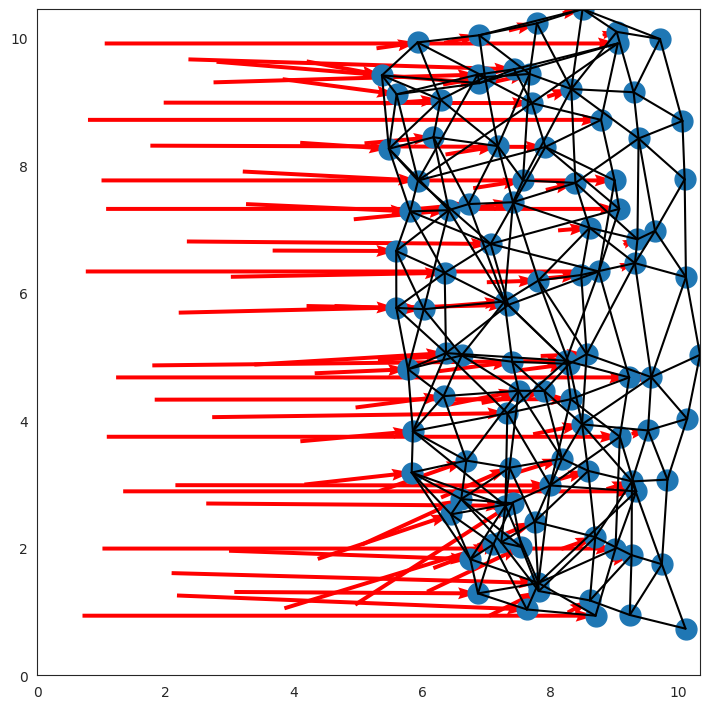

In [50]:
# Your existing setup
ms = 30
R_plt = np.array(R_final)  # Assuming R_final is already defined

# Plotting atoms
plt.plot(R_plt[:N, 0], R_plt[:N, 1], 'o', markersize=ms * 0.5)

# Plotting bonds
for bond in E:  # Assuming E is your list of bonds
    point1 = R_plt[bond[0]]
    point2 = R_plt[bond[1]]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], c='black')  # Bond color

# Calculate displacement vectors
displacements = R_final - R_init # Assuming R_initial is defined

# Create quiver plot for displacements
plt.quiver(R_init[:, 0], R_init[:, 1], displacements[:, 0], displacements[:, 1], 
           color='red', scale=1, scale_units='xy', angles='xy')  # Adjust color and scale as needed

# Setting plot limits
plt.xlim([0, np.max(R_plt[:, 0])])
plt.ylim([0, np.max(R_plt[:, 1])])

plt.axis('on')

# Assuming finalize_plot is a function you've defined
finalize_plot((1, 1))

In [ ]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from JSAnimation.IPython_display import display_animation
from IPython.display import HTML

# Set style
sns.set_style(style='white')
plt.xlim([0, np.max(traj[:, :, 0])])
plt.ylim([0, np.max(traj[:, :, 1])])
# Define the init function, which sets up the plot
def init():
    plt.axis('on')
    return plt

# Define the update function, which is called for each frame
def update(frame):
    plt.clf()  # Clear the current figure
    R_plt = traj[frame]
    plt.plot(R_plt[:N, 0], R_plt[:N, 1], 'o', markersize=ms * 0.5)

    # Plotting bonds
    for bond in E:
        point1 = R_plt[bond[0]]
        point2 = R_plt[bond[1]]
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], c='black')  # Using black for bond color
    return plt

# Create the animation
ani = FuncAnimation(plt.figure(), update, frames=range(len(traj)), init_func=init, blit=False)

# Display the animation
HTML(ani.to_jshtml())